In [5]:
# Asthetics
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Basic
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import json
import os
import glob
from collections import defaultdict
from textblob import TextBlob
import random
from tqdm.autonotebook import tqdm
import string
import re
from functools import partial

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from wordcloud import WordCloud, STOPWORDS

# NLP
import nltk
import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.max_length = 40000000
from nltk.probability import FreqDist

os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data/')

['sample_submission.csv', 'train.csv', 'test', 'train']

# Data Description
train.csv -labels and metadata for the training set train/tezt directory - the full text of the training/test set's publications in JSON format, broken into sections with section titles

* `id` - publication id - note that there are multiple rows for some training documents, indicating multiple mentioned datasets.
* `pub_title` - title of the publication (a small number of publications have the same title).
* `dataset_title`  - the title of the dataset that is mentioned within the publication.
* `dataset_label`  - a portion of the text that indicates the dataset.
* `cleaned_label` - the dataset_label, as passed through the clean_text function from the [Evaluation page](https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/overview/evaluation).

sample_submission.csv - a sample submission file in the correct format.

* `Id` - publication id.
* `PredictionString` - To be filled with equivalent of cleaned_label of train data.

In [6]:
# reading in the csv files,train, & test file paths
train_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')
sample_sub = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
train_files_path = '../input/coleridgeinitiative-show-us-the-data/train'
test_files_path = '../input/coleridgeinitiative-show-us-the-data/test'

Next step is to have a look at the training data csv file...

In [7]:
train_df.head(10)

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
5,81b5f874-9b42-4d4f-8c50-b4bab24f8aed,The Gender Gap Reloaded: Are School Characteri...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
6,f35fdfa6-a3f9-4ef3-a858-c8e2efcd2349,The High School Environment and the Gender Gap...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
7,1b21f60a-4022-4b19-95ce-6fd7157d4aa9,Examining Latinos Involvement in the Workforce...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
8,e5a4c6af-0854-4f7e-b088-06f03c18a01a,Locus of Control and Peer Relationships Among ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
9,4e18b1c7-e195-46e2-af0f-78757259f0c6,The Role of Research in Catholic Education,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


Let's get the text data from json files and append them to the table.

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19661 entries, 0 to 19660
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             19661 non-null  object
 1   pub_title      19661 non-null  object
 2   dataset_title  19661 non-null  object
 3   dataset_label  19661 non-null  object
 4   cleaned_label  19661 non-null  object
dtypes: object(5)
memory usage: 768.1+ KB


Since we don't have any null values we can move to the next step.

In [9]:
# finding unique values in each column
[print(f"{col}:{len(train_df[col].unique())}") for col in train_df.columns]

Id:14316
pub_title:14271
dataset_title:45
dataset_label:130
cleaned_label:130


[None, None, None, None, None]

In [11]:
def read_append_return(filename, train_files_path=train_files_path, output='text'):
    """Function to read json file and then return the text data from them and append to the dataframe"""
    json_path = os.path.join(train_files_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
            
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = ' '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

In [12]:
tqdm.pandas()   #tqdm is used to show any code running with a progress bar.
train_df['text'] = train_df['Id'].progress_apply(read_append_return)

  0%|          | 0/19661 [00:00<?, ?it/s]

In [13]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study used data from the National Educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,", stress satisfactory outcomes for all youth,..."
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Federal Reserve Bank of Richmond S1. Accountin...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This article investigates an important factor ...


We have our text appended in our train dataframe. so on to the next step

In [14]:
%%time
tqdm.pandas()
sample_sub['text'] = sample_sub['Id'].progress_apply(partial(read_append_return, train_files_path=test_files_path))

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 47.5 ms, sys: 1.1 ms, total: 48.6 ms
Wall time: 76.4 ms


In [15]:
sample_sub.head()

,Id,PredictionString,text
0,2100032a-7c33-4bff-97ef-690822c43466,NaN,Cognitive deficits and reduced educational ach...
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN,This report describes how the education system...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN,"Cape Hatteras National Seashore (CAHA), locate..."
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN,A significant body of research has been conduc...


Now we also have the text for the sample_submission file

In [17]:
def text_cleaning(text):
    """Converts all text to lower case, Removes special characters, emojis and multiple spaces
    text = Sentence that needs to be cleaned"""
    text = ''.join([k for k in text if k not in string.punctuation])
    text = re.sub('r[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    text = re.sub(' +', ' ', text)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [18]:
tqdm.pandas()
train_df['text'] = train_df['text'].progress_apply(text_cleaning)

  0%|          | 0/19661 [00:00<?, ?it/s]

In [ ]:
# tqdm.pandas()
# sample_sub['text'] = sample_sub['text'].progress_apply(text_cleaning)

# ****Data Visualization****

In [20]:
words = list( train_df['cleaned_label'].values)
stopwords=['ourselves', 'hers','the','of','and','in', 'between', 'yourself', 'but', 'again','of', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
split_words=[]
for word in words:
    lo_w=[]
    list_of_words=str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist

**100 Most common words (cleaned_label)**

# **Generating A Word Cloud**

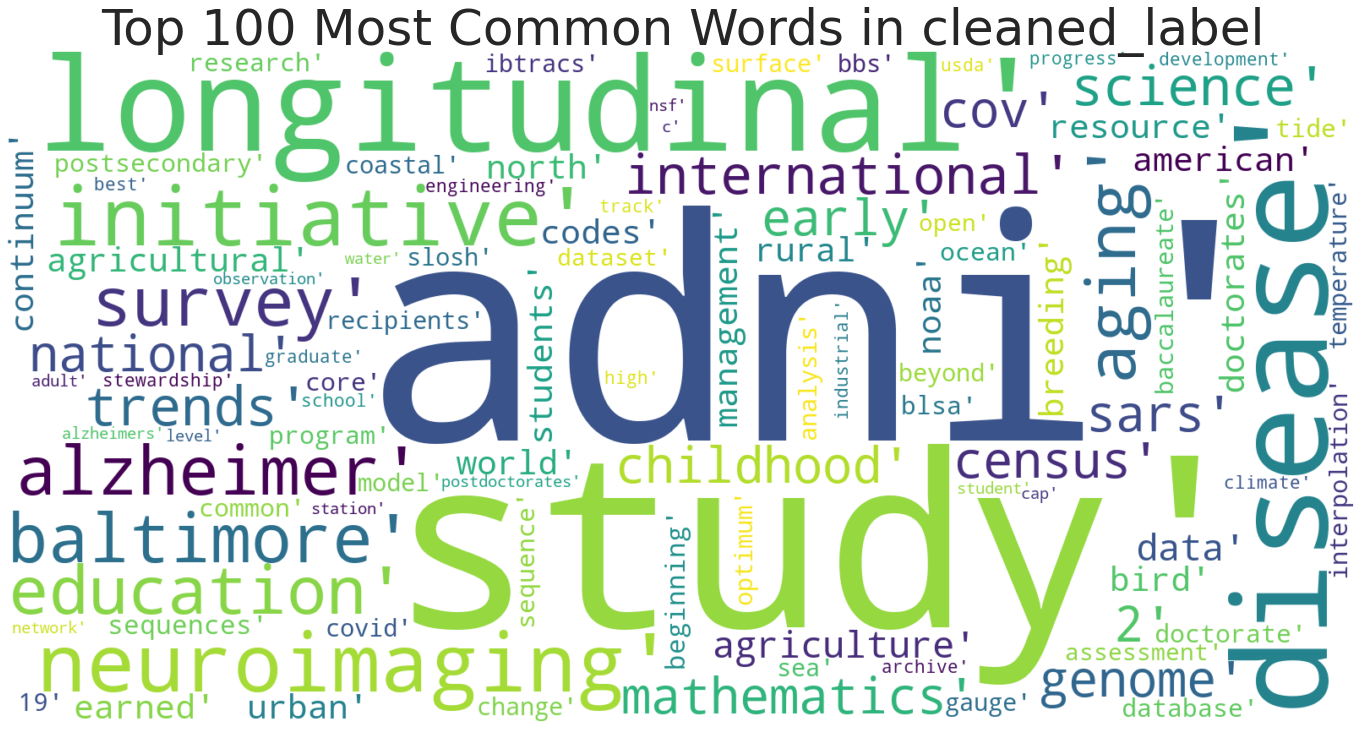

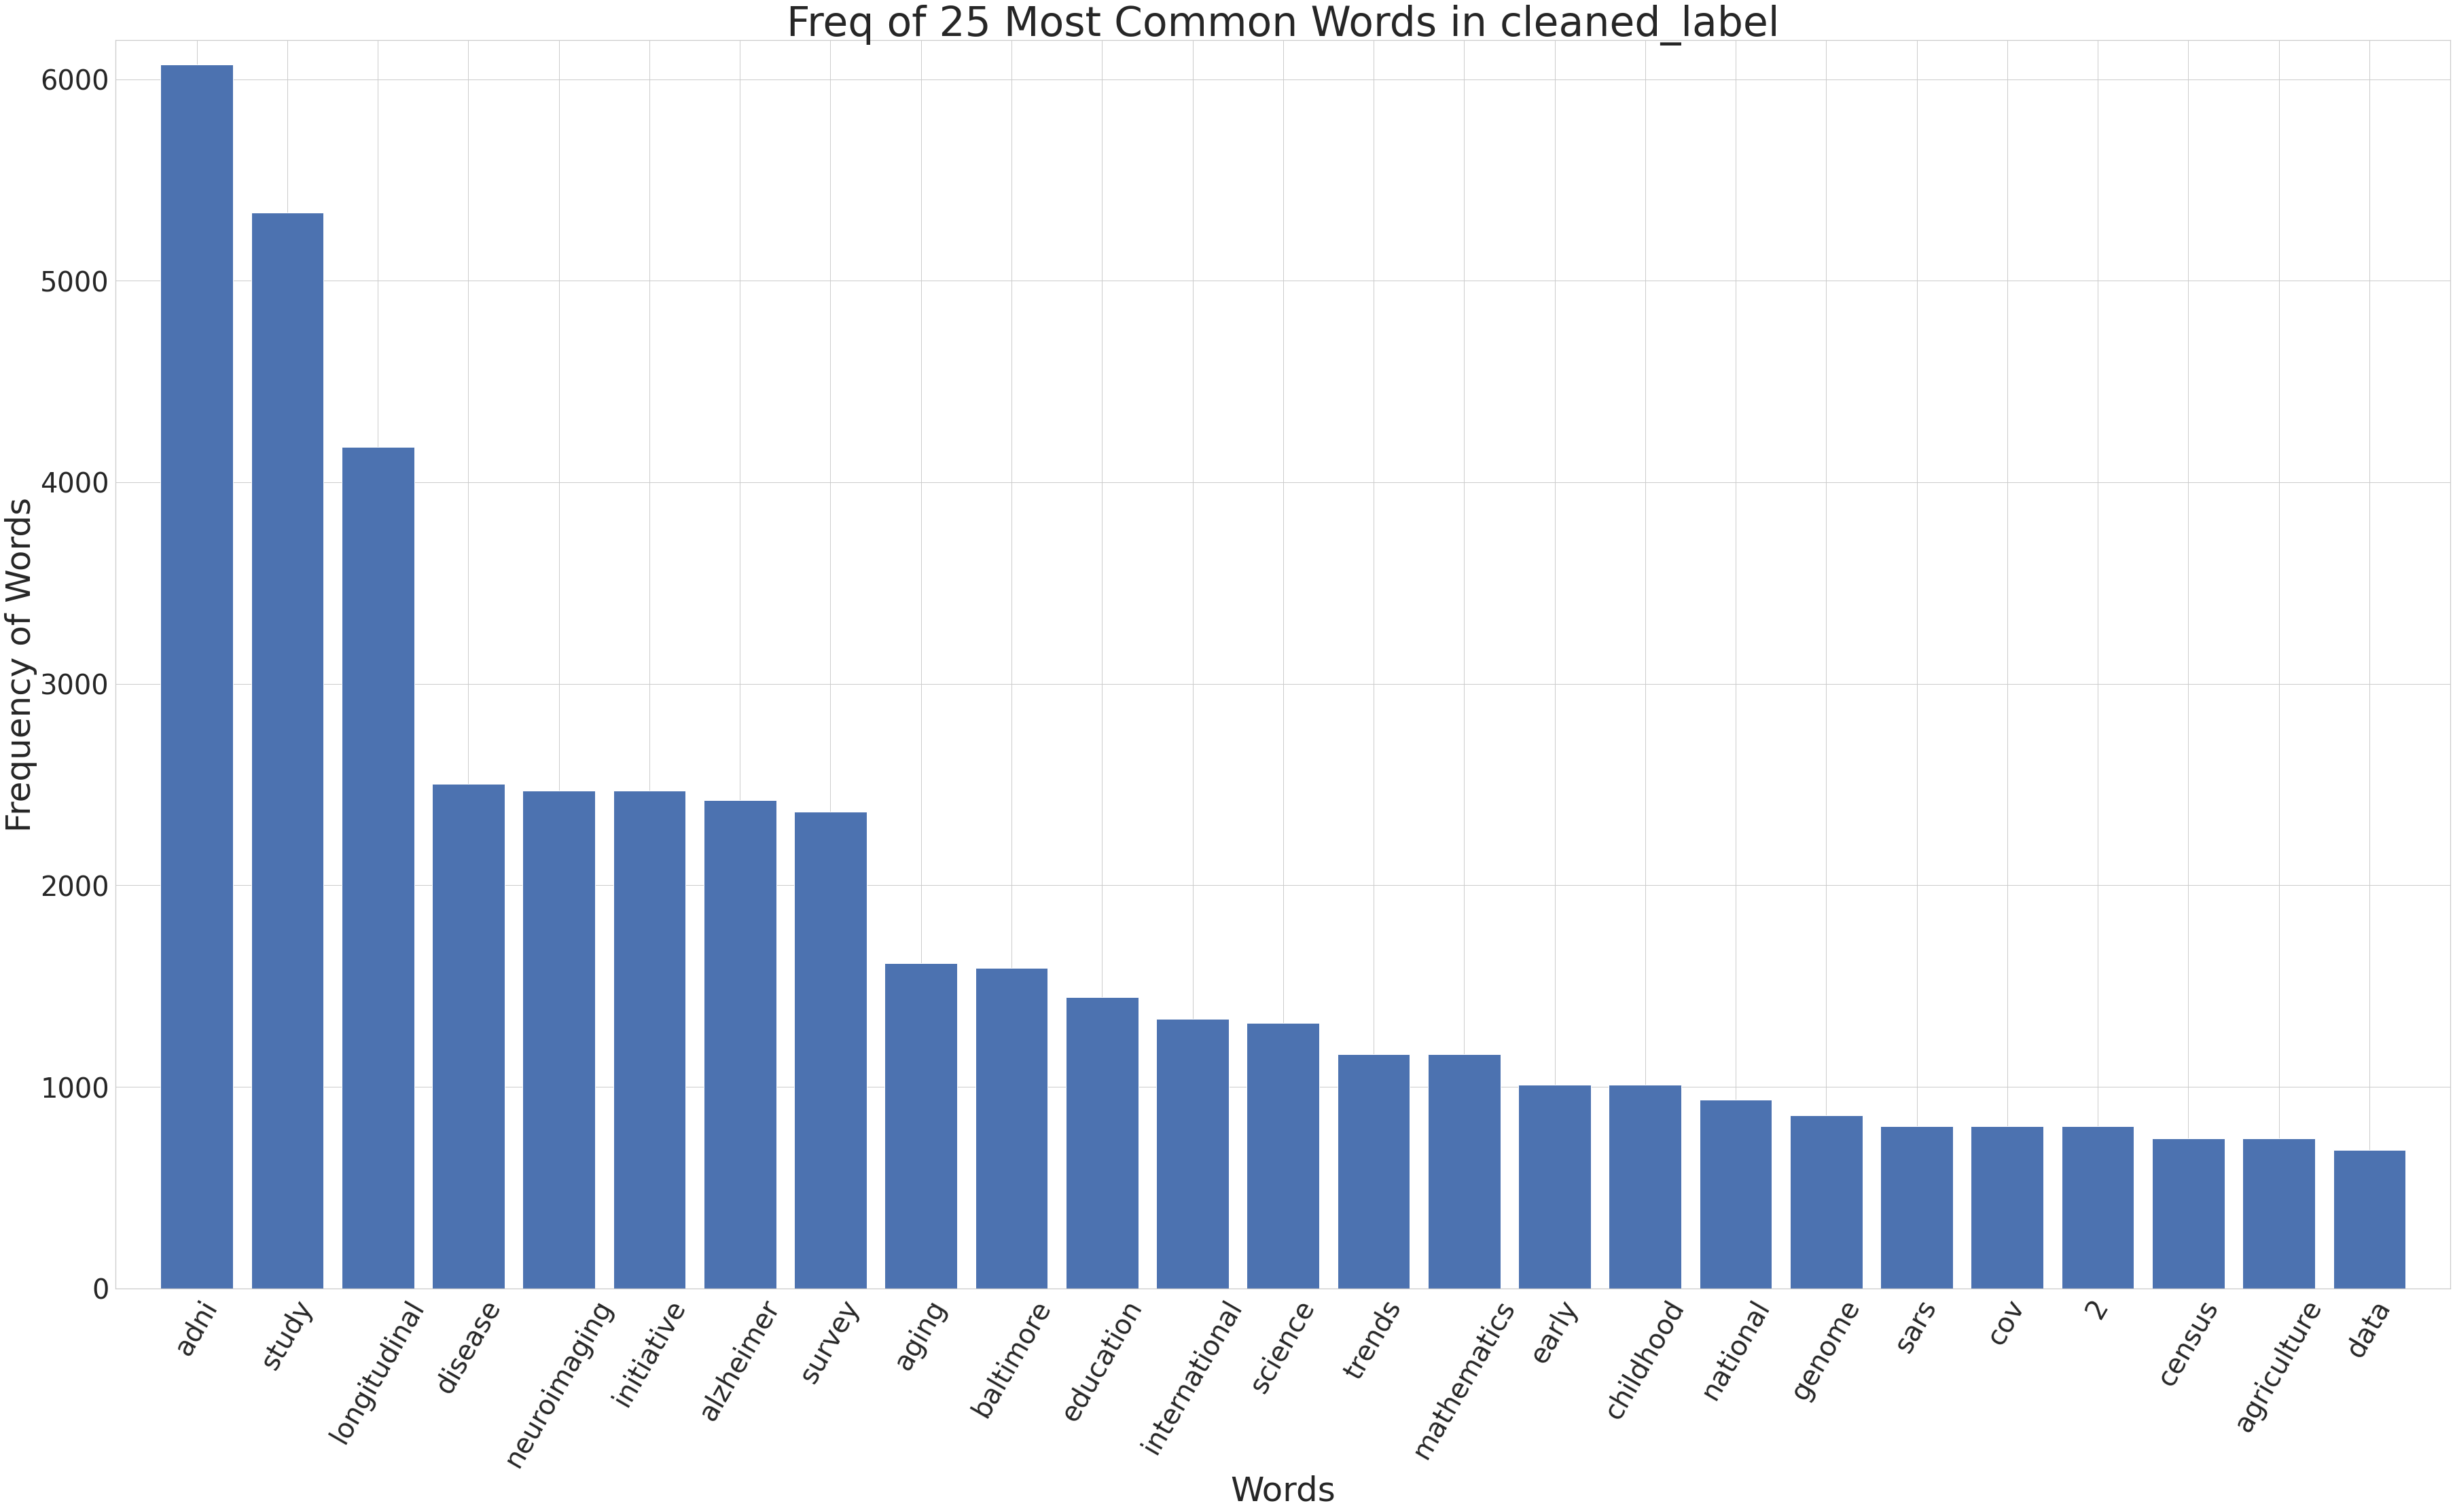

In [21]:
mostcommon = FreqDist(allwords).most_common(100)
text = ' '.join(train_df['text'].sample(frac=0.3))
wordcloud = WordCloud(background_color='white', stopwords=STOPWORDS, width=1600, height=800).generate(str(mostcommon))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Top 100 Most Common Words in cleaned_label', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('Freq of 25 Most Common Words in cleaned_label', fontsize=60)
plt.show()

There are mentions of "et al" pretty frequently in the test of papers. Which is in fact related to quoting papers. This should be a significant factor in determining the citation titles.

# Preparing Text

In [24]:
def prepare_text(text, nlp=nlp):
    """Returns the text after the stop-wrd removal and lemmatization.
    text = Sentence to be processed.
    nlp = Spacy NLP model"""
    doc = nlp(text)
    lemma_list = [token.lemma_ for token in doc if not token.is_stop]
    lemmatized_sentence = ' '.join(lemma_list)
        
    return lemmatized_sentence

In [ ]:
# tqdm.pandas()
# train_df['text'] = train_df['text'].progress_apply(prepare_text)

# Model
This is a very naive model based on the assumption that topics having names of label or dataset_title in their content are probably citing the same sources.

In [26]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

In [ ]:
# %%time
# tqdm.pandas()
# train_df['text'] = train_df['text'].progress_apply(prepare_text)

# **Baseline Model and Submission**

In [29]:
temp_1 = [x.lower() for x in train_df['dataset_label'].unique()]
temp_2 = [x.lower() for x in train_df['dataset_title'].unique()]
temp_3 = [x.lower() for x in train_df['cleaned_label'].unique()]

existing_labels = set(temp_1 + temp_2 + temp_3)
id_list = []
labels_list = []
for index, row in tqdm(sample_sub.iterrows()):
    sample_text = row['text']
    row_id = row['Id']
    temp_df = train_df[train_df['text'] == text_cleaning(sample_text)]
    cleaned_labels = temp_df['cleaned_label'].to_list()
    for known_label in existing_labels:
        if known_label in sample_text.lower():
            cleaned_labels.append(clean_text(known_label))
    cleaned_labels = [clean_text(x) for x in cleaned_labels]
    cleaned_labels = set(cleaned_labels)
    labels_list.append('|'.join(cleaned_labels))
    id_list.append(row_id)

0it [00:00, ?it/s]

In [32]:
submission = pd.DataFrame()
submission['Id'] = id_list
submission['PredictionString'] = labels_list

In [33]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
submission.head()

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,alzheimer s disease neuroimaging initiative ad...
1,2f392438-e215-4169-bebf-21ac4ff253e1,trends in international mathematics and scienc...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,sea lake and overland surges from hurricanes|n...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes


In [ ]:
submission.to_csv('submission.csv', index=False)